# Predict BTC/USD value with tweets and text mining

## Index

1. [Twitter scraping](#ts)<br>
2. [Download BTC data](#btc)<br>
3. [Text mining](#tm)<br>
4. [Classic approach of time series - ARIMA model](#ar)<br>
5. [Exploratory analysis](#ae)<br>
6. [Classification models](#mod)<br>
7. [Pipeline](#pip)<br>

## 1. Twitter scraping<a id=ts> </a>

### Import the libraries

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import multiprocessing as mp
import threading as th
import warnings
from matplotlib.cbook import mplDeprecation
warnings.filterwarnings("ignore", category=mplDeprecation)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore')
try:
    from twitterscraper import query_tweets_from_user
except Exception:
    pass
try:
    from twitterscraper import query_tweets
except Exception:
    pass
import pickle
from sklearn.pipeline import Pipeline
import quandl as q
from bs4 import BeautifulSoup as bs
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords as sw
from string import punctuation as pun
from nltk.tokenize import TweetTokenizer as tt
from nltk.stem.snowball import SnowballStemmer as ss
import re
from sklearn.pipeline import FeatureUnion, Pipeline 

INFO: {'User-Agent': 'Mozilla/5.0 (Windows; U; Windows NT 6.1; rv:2.2) Gecko/20110201'}
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALBERTO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Scraping of tweets contained in Twitter pages

In [47]:
def user_scraper(user, coda=None):
    tweets = query_tweets_from_user(user)
    df = pd.DataFrame(t.__dict__ for t in tweets)
    if coda is None:
        return df
    else:
        coda.put(df)
        
def users_scraper(users):
    coda = mp.Queue()
    threads = [th.Thread(target=user_scraper, args=(user,), kwargs={"coda": coda}) for user in users]
    for t in threads:
        t.start()
    dfs = [coda.get() for t in threads]
    for t in threads:
        t.join()
    df = pd.concat((df.set_index("text") for df in dfs), join="inner").reset_index()
    df = df[["timestamp","text"]]
    date = [str(d)[0:10] for d in df.timestamp]
    #date = [datetime.strptime(d,"%Y-%m-%d") for d in date]
    df.timestamp = date
    df.columns = ["Date","Text"]
    df = df.sort_values(by=["Date"])
    df = df.reset_index(drop=True)
    return df

In [49]:
profiles = ["BTCTN","Bitcoin","BTCNews247","justinsuntron","officialmcafee","VitalikButerin","SatoshiLite","APompliano",
           "naval","pmarca","fredwilson","rogerkver","cdixon","aantonop","cz_binance","ErikVoorhees","PeterLBrandt",
           "brian_armstrong"]
df = users_scraper(profiles)
n = len(df)
print(n)

INFO: Scraping tweets from https://twitter.com/BTCTN
INFO: Scraping tweets from https://twitter.com/Bitcoin
INFO: Scraping tweets from https://twitter.com/BTCNews247
INFO: Using proxy 161.35.130.184:8080
INFO: Scraping tweets from https://twitter.com/justinsuntron
INFO: Using proxy 75.150.251.146:3128
INFO: Scraping tweets from https://twitter.com/officialmcafee
INFO: Scraping tweets from https://twitter.com/VitalikButerin
INFO: Scraping tweets from https://twitter.com/SatoshiLite
INFO: Using proxy 103.216.82.214:6666
INFO: Using proxy 46.255.99.184:41258
INFO: Scraping tweets from https://twitter.com/APompliano
INFO: Scraping tweets from https://twitter.com/naval
INFO: Scraping tweets from https://twitter.com/pmarca
INFO: Using proxy 42.3.51.114:80
INFO: Scraping tweets from https://twitter.com/fredwilson
INFO: Using proxy 202.162.196.167:80
INFO: Scraping tweets from https://twitter.com/rogerkver
INFO: Using proxy 98.158.58.104:8080
INFO: Scraping tweets from https://twitter.com/cdix

INFO: Using proxy 160.202.40.20:55655
INFO: Scraping tweets from https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1259159294148149256&reset_error_state=false
INFO: Using proxy 103.216.82.216:6666
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=1204800971211063296&reset_error_state=false
INFO: Using proxy 185.134.23.196:80
INFO: Scraping tweets from https://twitter.com/i/profiles/show/brian_armstrong/timeline/tweets?include_available_features=1&include_entities=1&max_position=1261020994447093760&reset_error_state=false
INFO: Using proxy 82.119.170.106:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1263692056871882752&reset_error_state=false
INFO: Using proxy 138.255.73.228:61940
INFO: Scraping tweets

INFO: Using proxy 46.218.155.194:3128
INFO: Scraping tweets from https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=1239701430652428288&reset_error_state=false
INFO: Using proxy 47.52.231.140:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=1123248429835214853&reset_error_state=false
INFO: Using proxy 12.139.101.102:80
INFO: Scraping tweets from https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252452891383611393&reset_error_state=false
INFO: Using proxy 200.255.122.170:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/BTCNews247/timeline/tweets?include_available_features=1&include_entities=1&max_position=442889261264535552&reset_error_state=false
INFO: Using proxy 80.48.119.28:8080
INFO: Scraping tweets from https:/

INFO: Scraping tweets from https://twitter.com/i/profiles/show/pmarca/timeline/tweets?include_available_features=1&include_entities=1&max_position=1014987920304832512&reset_error_state=false
INFO: Using proxy 46.4.96.87:80
INFO: Scraping tweets from https://twitter.com/i/profiles/show/BTCNews247/timeline/tweets?include_available_features=1&include_entities=1&max_position=442507255863181313&reset_error_state=false
INFO: Using proxy 188.226.141.61:3128
INFO: Scraping tweets from https://twitter.com/i/profiles/show/cz_binance/timeline/tweets?include_available_features=1&include_entities=1&max_position=1260131649615880192&reset_error_state=false
INFO: Using proxy 200.49.48.124:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=1057631547526922240&reset_error_state=false
INFO: Using proxy 161.202.226.194:8123
INFO: Twitter returned : 'has_more_items' 
INFO: Got 63 tweets from username pm

INFO: Using proxy 88.99.10.254:1080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/BTCTN/timeline/tweets?include_available_features=1&include_entities=1&max_position=1251286918412845059&reset_error_state=false
INFO: Using proxy 88.99.10.255:1080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1255739356037480450&reset_error_state=false
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=996890744794308609&reset_error_state=false
INFO: Using proxy 89.251.70.61:38408
INFO: Using proxy 86.57.177.8:39217
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1256090959810527232&reset_error_state=false
INFO: Using proxy 37.120.192.154:8080
INFO: Scraping tweets from https://twitter

INFO: Retrying... (Attempts left: 50)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1255493101528940544&reset_error_state=false
INFO: Using proxy 36.89.192.119:52313
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1254826941749661697&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.

INFO: Retrying... (Attempts left: 49)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1255493101528940544&reset_error_state=false
INFO: Using proxy 180.183.67.201:8080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1254826941749661697&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.

INFO: Retrying... (Attempts left: 50)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1238535191699902465&reset_error_state=false
INFO: Using proxy 149.129.119.170:80
INFO: Scraping tweets from https://twitter.com/i/profiles/show/VitalikButerin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1246568223908270093&reset_error_state=false
INFO: Using proxy 149.129.240.89:8080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/naval/timeline/tweets?include_available_features=1&include_entities=1&max_position=1253493661871955969&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.

ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1226267947238166528&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value:

INFO: Retrying... (Attempts left: 47)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1255493101528940544&reset_error_state=false
INFO: Using proxy 209.190.32.28:3128
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/naval/timeline/tweets?include_available_features=1&include_entities=1&max_position=1253493661871955969&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py"

INFO: Retrying... (Attempts left: 50)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1260328091924258816&reset_error_state=false
INFO: Using proxy 79.175.176.254:3128
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1241545769640816642&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder

INFO: Retrying... (Attempts left: 48)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1238535191699902465&reset_error_state=false
INFO: Using proxy 94.228.29.152:8080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1253764759310274561&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py

INFO: Retrying... (Attempts left: 48)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/cz_binance/timeline/tweets?include_available_features=1&include_entities=1&max_position=1255696452208091138&reset_error_state=false
INFO: Using proxy 186.248.170.82:53281
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1259110237681807362&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decod

INFO: Retrying... (Attempts left: 46)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=981522762413068294&reset_error_state=false
INFO: Using proxy 144.34.180.240:8080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/BTCTN/timeline/tweets?include_available_features=1&include_entities=1&max_position=1249732684164861955&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", li

INFO: Retrying... (Attempts left: 47)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/naval/timeline/tweets?include_available_features=1&include_entities=1&max_position=1253493661871955969&reset_error_state=false
INFO: Using proxy 180.183.131.215:8213
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/VitalikButerin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1246568223908270093&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.p

INFO: Retrying... (Attempts left: 47)
INFO: Retrying... (Attempts left: 48)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1241545769640816642&reset_error_state=false
INFO: Scraping tweets from https://twitter.com/i/profiles/show/BTCNews247/timeline/tweets?include_available_features=1&include_entities=1&max_position=441600212012781568&reset_error_state=false
INFO: Using proxy 101.109.192.246:8213
INFO: Using proxy 180.183.97.245:8213
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1226267947238166528&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\ana

ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/brian_armstrong/timeline/tweets?include_available_features=1&include_entities=1&max_position=1233061158413688832&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting va

INFO: Retrying... (Attempts left: 46)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/cz_binance/timeline/tweets?include_available_features=1&include_entities=1&max_position=1255696452208091138&reset_error_state=false
INFO: Using proxy 3.249.104.236:3128
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/cdixon/timeline/tweets?include_available_features=1&include_entities=1&max_position=856061186755805184&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", li

INFO: Retrying... (Attempts left: 44)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=981522762413068294&reset_error_state=false
INFO: Using proxy 88.99.10.253:1080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/naval/timeline/tweets?include_available_features=1&include_entities=1&max_position=1253493661871955969&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line

INFO: Retrying... (Attempts left: 43)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1260328091924258816&reset_error_state=false
INFO: Retrying... (Attempts left: 43)
INFO: Using proxy 88.99.10.250:1080
INFO: Retrying... (Attempts left: 47)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1253764759310274561&reset_error_state=false
INFO: Scraping tweets from https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1254826941749661697&reset_error_state=false
INFO: Using proxy 87.76.34.88:35782
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1255493101528940544&reset_error_state=false
ERROR: Failed to parse JSON "Expect

ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1226267947238166528&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value:

INFO: Using proxy 187.47.68.176:8080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=1196156028611682305&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decode

INFO: Using proxy 161.35.130.184:8080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/cz_binance/timeline/tweets?include_available_features=1&include_entities=1&max_position=1255696452208091138&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.deco

INFO: Retrying... (Attempts left: 45)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=1196156028611682305&reset_error_state=false
INFO: Using proxy 103.31.227.27:8080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/BTCNews247/timeline/tweets?include_available_features=1&include_entities=1&max_position=441600212012781568&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py",

INFO: Scraping tweets from https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1253764759310274561&reset_error_state=false
INFO: Using proxy 46.4.96.67:80
INFO: Retrying... (Attempts left: 45)
INFO: Retrying... (Attempts left: 42)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1260328091924258816&reset_error_state=false
INFO: Scraping tweets from https://twitter.com/i/profiles/show/BTCTN/timeline/tweets?include_available_features=1&include_entities=1&max_position=1249732684164861955&reset_error_state=false
INFO: Using proxy 187.130.139.197:8080
INFO: Using proxy 169.57.157.146:8123
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/brian_armstrong/timeline/tweets?include_available_features=1&include_entities=1&max_position=123306115841368883

INFO: Retrying... (Attempts left: 41)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1255493101528940544&reset_error_state=false
INFO: Using proxy 183.89.144.11:8213
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=981522762413068294&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder

INFO: Retrying... (Attempts left: 44)
INFO: Retrying... (Attempts left: 44)
INFO: Retrying... (Attempts left: 42)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1253764759310274561&reset_error_state=false
INFO: Scraping tweets from https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1260328091924258816&reset_error_state=false
INFO: Scraping tweets from https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1238535191699902465&reset_error_state=false
INFO: Using proxy 110.168.26.35:8213
INFO: Using proxy 36.80.17.31:8080
INFO: Using proxy 61.90.7.121:8213
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/BTCNews247/timeline/tweets?include_available_features=1&include_enti

INFO: Retrying... (Attempts left: 43)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/VitalikButerin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1246568223908270093&reset_error_state=false
INFO: Using proxy 154.127.119.93:80
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/BTCTN/timeline/tweets?include_available_features=1&include_entities=1&max_position=1249732684164861955&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py",

INFO: Retrying... (Attempts left: 41)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/naval/timeline/tweets?include_available_features=1&include_entities=1&max_position=1253493661871955969&reset_error_state=false
INFO: Using proxy 200.89.178.156:80
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1254826941749661697&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 3

INFO: Using proxy 41.65.146.38:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1211510006626967552&reset_error_state=false
INFO: Using proxy 178.33.251.230:3129
INFO: Scraping tweets from https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252249410362277888&reset_error_state=false
INFO: Using proxy 169.57.1.84:8123
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1258419510450597888&reset_error_state=false
INFO: Using proxy 171.244.19.228:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=1180212434889510913&reset_error_state=false
INFO: Using proxy 134.209.29.120:3128
INFO: Scraping tweets from https:/

INFO: Scraping tweets from https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1196516752298934272&reset_error_state=false
INFO: Using proxy 85.10.219.98:1080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1247485481413214209&reset_error_state=false
INFO: Using proxy 51.158.99.51:8811
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1257734228520943616&reset_error_state=false
INFO: Using proxy 51.158.108.135:8811
INFO: Scraping tweets from https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=1163832670301724672&reset_error_state=false
INFO: Using proxy 51.158.98.121:8811
INFO: Scraping tweets from https://twitter.com/i/profiles/show/aan

INFO: Using proxy 36.68.46.230:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/cz_binance/timeline/tweets?include_available_features=1&include_entities=1&max_position=1242674194296344576&reset_error_state=false
INFO: Using proxy 212.83.183.73:5836
INFO: Scraping tweets from https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1230563222043758595&reset_error_state=false
INFO: Using proxy 198.199.86.11:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1198947381678616581&reset_error_state=false
INFO: Using proxy 138.68.60.8:3128
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1243815788605210624&reset_error_state=false
INFO: Using proxy 191.233.198.207:8080
INFO: Scraping tweets from h

INFO: Using proxy 36.89.192.119:52313
INFO: Scraping tweets from https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1245440570157400065&reset_error_state=false
INFO: Using proxy 18.228.254.92:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1241377397221601280&reset_error_state=false
INFO: Using proxy 125.212.218.43:8888
INFO: Scraping tweets from https://twitter.com/i/profiles/show/brian_armstrong/timeline/tweets?include_available_features=1&include_entities=1&max_position=1187925480420368384&reset_error_state=false
INFO: Using proxy 93.117.72.27:32468
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1255042470821289984&reset_error_state=false
INFO: Using proxy 118.174.220.11:60148
INFO: Scraping tweets

ERROR: ConnectionError ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')")) while requesting "https://twitter.com/i/profiles/show/naval/timeline/tweets?include_available_features=1&include_entities=1&max_position=1245536546356441088&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\Users\Max\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Users\Max\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 416, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\Max\anaconda3\lib\http\client.py", line 1344, in getresponse
    response.begin()
  File "C:\Users\Max\anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Max\anaconda3\lib\http\c

INFO: Scraping tweets from https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=1108026430565175296&reset_error_state=false
INFO: Got 230 tweets from username naval.
INFO: Using proxy 188.165.141.114:3129
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=825757863255478273&reset_error_state=false
INFO: Using proxy 41.220.114.154:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1254003236467388416&reset_error_state=false
INFO: Using proxy 185.93.71.119:3128
ERROR: An unknown error occurred! Returning tweets gathered so far.
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 255, in query_tweets_from_user
    new_tweets, pos = query_single_page(user

INFO: Using proxy 180.183.131.215:8213
INFO: Scraping tweets from https://twitter.com/i/profiles/show/BTCTN/timeline/tweets?include_available_features=1&include_entities=1&max_position=1229751682453704705&reset_error_state=false
INFO: Using proxy 180.180.128.128:8213
INFO: Scraping tweets from https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1238489752476602368&reset_error_state=false
INFO: Using proxy 183.88.78.23:8213
INFO: Scraping tweets from https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1159828348786421761&reset_error_state=false
INFO: Using proxy 14.207.14.198:8213
INFO: Scraping tweets from https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1212444629951565826&reset_error_state=false
INFO: Using proxy 14.207.15.207:8213
INFO: Scraping tweets from https://t

INFO: Retrying... (Attempts left: 50)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1132803800748527616&reset_error_state=false
INFO: Using proxy 87.76.34.88:35782
INFO: Scraping tweets from https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1206035688149282821&reset_error_state=false
INFO: Using proxy 95.38.14.3:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1236625130513711105&reset_error_state=false
INFO: Using proxy 144.76.214.157:1080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252207632678621184&reset_error_state=false
INFO: Using proxy 167.172.136.107:80
ERROR: Failed to parse JSON "E

INFO: Retrying... (Attempts left: 49)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1132803800748527616&reset_error_state=false
INFO: Using proxy 109.87.48.66:34996
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1206035688149282821&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder

INFO: Retrying... (Attempts left: 50)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/cz_binance/timeline/tweets?include_available_features=1&include_entities=1&max_position=1229516578296860673&reset_error_state=false
INFO: Using proxy 163.172.136.226:8811
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/BTCTN/timeline/tweets?include_available_features=1&include_entities=1&max_position=1227599815304810496&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", 

INFO: Retrying... (Attempts left: 50)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/brian_armstrong/timeline/tweets?include_available_features=1&include_entities=1&max_position=1148309232971743232&reset_error_state=false
INFO: Using proxy 42.3.51.114:80
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1241911222800396297&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py"

INFO: Retrying... (Attempts left: 48)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/BTCTN/timeline/tweets?include_available_features=1&include_entities=1&max_position=1227599815304810496&reset_error_state=false
INFO: Using proxy 181.117.176.236:61358
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1235235314668572675&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", li

INFO: Retrying... (Attempts left: 48)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1236625130513711105&reset_error_state=false
INFO: Using proxy 94.103.12.106:3838
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1241911222800396297&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.

INFO: Retrying... (Attempts left: 47)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1235235314668572675&reset_error_state=false
INFO: Using proxy 110.168.26.35:8213
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1146451121071951875&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py"

INFO: Using proxy 36.77.24.85:80
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252207632678621184&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.J

INFO: Retrying... (Attempts left: 46)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1146451121071951875&reset_error_state=false
INFO: Using proxy 159.8.114.34:8123
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1132803800748527616&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.

INFO: Retrying... (Attempts left: 44)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=1075410535561056256&reset_error_state=false
INFO: Using proxy 160.202.40.20:55655
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252414984300052482&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder

INFO: Retrying... (Attempts left: 44)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1132803800748527616&reset_error_state=false
INFO: Using proxy 35.189.128.127:8888
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1206035688149282821&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decode

INFO: Retrying... (Attempts left: 44)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252414984300052482&reset_error_state=false
INFO: Using proxy 163.172.190.160:8811
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/brian_armstrong/timeline/tweets?include_available_features=1&include_entities=1&max_position=1142641686062874624&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\

INFO: Using proxy 36.77.255.16:3128
INFO: Retrying... (Attempts left: 44)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1206035688149282821&reset_error_state=false
INFO: Using proxy 103.233.198.156:8081
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=760896653536657409&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\

INFO: Retrying... (Attempts left: 45)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1241911222800396297&reset_error_state=false
INFO: Using proxy 134.209.29.120:3128
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1235235314668572675&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", l

INFO: Retrying... (Attempts left: 44)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=760896653536657409&reset_error_state=false
INFO: Using proxy 185.156.173.154:80
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252207632678621184&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py"

INFO: Retrying... (Attempts left: 42)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252414984300052482&reset_error_state=false
INFO: Using proxy 103.221.254.2:44195
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1235235314668572675&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.p

INFO: Retrying... (Attempts left: 42)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252207632678621184&reset_error_state=false
INFO: Using proxy 144.76.214.155:1080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1236625130513711105&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decod

INFO: Scraping tweets from https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=1075410535561056256&reset_error_state=false
INFO: Retrying... (Attempts left: 41)
INFO: Retrying... (Attempts left: 41)
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252414984300052482&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder

INFO: Retrying... (Attempts left: 41)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252207632678621184&reset_error_state=false
INFO: Using proxy 51.158.108.135:8811
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1236625130513711105&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decod

INFO: Retrying... (Attempts left: 40)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252414984300052482&reset_error_state=false
INFO: Using proxy 94.179.135.230:54393
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/BTCTN/timeline/tweets?include_available_features=1&include_entities=1&max_position=1227599815304810496&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py

INFO: Retrying... (Attempts left: 41)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=760896653536657409&reset_error_state=false
INFO: Using proxy 103.105.49.53:80
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=1075410535561056256&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", l

INFO: Retrying... (Attempts left: 39)
INFO: Retrying... (Attempts left: 39)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252414984300052482&reset_error_state=false
INFO: Scraping tweets from https://twitter.com/i/profiles/show/BTCTN/timeline/tweets?include_available_features=1&include_entities=1&max_position=1227599815304810496&reset_error_state=false
INFO: Using proxy 102.129.249.120:8080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1146451121071951875&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models

INFO: Using proxy 89.23.198.13:8080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=1075410535561056256&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder

INFO: Scraping tweets from https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1241911222800396297&reset_error_state=false
INFO: Retrying... (Attempts left: 38)
INFO: Using proxy 36.68.46.230:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1146451121071951875&reset_error_state=false
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/BTCTN/timeline/tweets?include_available_features=1&include_entities=1&max_position=1227599815304810496&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson

INFO: Retrying... (Attempts left: 37)
INFO: Retrying... (Attempts left: 37)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1235235314668572675&reset_error_state=false
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252414984300052482&reset_error_state=false
INFO: Using proxy 63.82.52.254:8080
INFO: Using proxy 88.198.24.108:8080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/brian_armstrong/timeline/tweets?include_available_features=1&include_entities=1&max_position=1142641686062874624&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anac

INFO: Using proxy 89.251.70.61:38408
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1206035688149282821&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.dec

INFO: Retrying... (Attempts left: 37)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1236625130513711105&reset_error_state=false
INFO: Using proxy 134.196.244.120:46425
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252207632678621184&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\dec

INFO: Retrying... (Attempts left: 35)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1235235314668572675&reset_error_state=false
INFO: Using proxy 36.66.137.181:44393
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1132803800748527616&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py"

INFO: Retrying... (Attempts left: 37)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=760896653536657409&reset_error_state=false
INFO: Using proxy 36.89.192.119:52313
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/cz_binance/timeline/tweets?include_available_features=1&include_entities=1&max_position=1229516578296860673&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py

INFO: Retrying... (Attempts left: 35)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1146451121071951875&reset_error_state=false
INFO: Using proxy 167.71.208.238:8080
ERROR: TimeOut HTTPSConnectionPool(host='twitter.com', port=443): Read timed out. (read timeout=60) while requesting "https://twitter.com/i/profiles/show/cdixon/timeline/tweets?include_available_features=1&include_entities=1&max_position=796737416627441664&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Users\Max\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 416, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\Max\anaconda3\lib\http\client.py", line 1344, in getresponse
    response.

INFO: Retrying... (Attempts left: 35)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1236625130513711105&reset_error_state=false
INFO: Using proxy 45.162.204.69:80
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1241911222800396297&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py

INFO: Retrying... (Attempts left: 49)
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=1075410535561056256&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decod

INFO: Using proxy 139.162.78.109:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=1065641391387262983&reset_error_state=false
INFO: Using proxy 198.199.120.102:3128
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1251483248804245504&reset_error_state=false
INFO: Using proxy 80.87.184.49:41258
INFO: Scraping tweets from https://twitter.com/i/profiles/show/cz_binance/timeline/tweets?include_available_features=1&include_entities=1&max_position=1227965284717416448&reset_error_state=false
INFO: Using proxy 209.190.32.28:3128
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1235529429528596482&reset_error_state=false
INFO: Using proxy 80.187.140.26:8080
INFO: Scraping tweets from

INFO: Using proxy 183.88.98.204:8213
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=713751072196526080&reset_error_state=false
INFO: Using proxy 171.100.221.211:8213
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1232944180156076033&reset_error_state=false
INFO: Using proxy 180.183.131.215:8213
INFO: Scraping tweets from https://twitter.com/i/profiles/show/cz_binance/timeline/tweets?include_available_features=1&include_entities=1&max_position=1222843789347368960&reset_error_state=false
INFO: Using proxy 180.180.128.128:8213
INFO: Scraping tweets from https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1126922176454701056&reset_error_state=false
INFO: Using proxy 183.88.78.23:8213
INFO: Scraping tweets fro

INFO: Using proxy 144.76.214.157:1080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=679005350960496640&reset_error_state=false
INFO: Using proxy 167.172.136.107:80
INFO: Scraping tweets from https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1192809641060659200&reset_error_state=false
INFO: Using proxy 136.243.92.25:1080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1112020931332001792&reset_error_state=false
INFO: Using proxy 144.76.214.159:1080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1228841557794705409&reset_error_state=false
INFO: Using proxy 34.91.139.91:3128
INFO: Scraping tweets from 

INFO: Using proxy 47.75.90.57:80
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1225456595880087552&reset_error_state=false
INFO: Using proxy 88.99.10.252:1080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=1005462868521832448&reset_error_state=false
INFO: Using proxy 94.103.12.106:3838
INFO: Scraping tweets from https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1187086353898409984&reset_error_state=false
INFO: Using proxy 110.168.175.101:8213
INFO: Scraping tweets from https://twitter.com/i/profiles/show/BTCTN/timeline/tweets?include_available_features=1&include_entities=1&max_position=1214940172758011904&reset_error_state=false
INFO: Using proxy 183.89.144.11:8213
INFO: Scraping tweets from https://twi

INFO: Retrying... (Attempts left: 50)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1086336619613872129&reset_error_state=false
INFO: Using proxy 3.91.220.193:3128
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1245233369253699584&reset_error_state=false
INFO: Using proxy 81.16.10.141:38132
INFO: Scraping tweets from https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1222989864905400325&reset_error_state=false
INFO: Using proxy 1.20.97.173:46790
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1247611540095860742&reset_error_state=false"
Tracebac

INFO: Retrying... (Attempts left: 50)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1245233369253699584&reset_error_state=false
INFO: Using proxy 35.189.128.127:8888
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1247611540095860742&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decode

INFO: Retrying... (Attempts left: 49)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1223586651127066627&reset_error_state=false
INFO: Using proxy 163.172.190.160:8811
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=987700520809783296&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decode

INFO: Retrying... (Attempts left: 48)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=617752671219523584&reset_error_state=false
INFO: Using proxy 103.233.198.156:8081
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1092906624954654720&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder

INFO: Retrying... (Attempts left: 46)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1247611540095860742&reset_error_state=false
INFO: Using proxy 134.209.29.120:3128
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1222989864905400325&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py",

INFO: Retrying... (Attempts left: 47)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1245233369253699584&reset_error_state=false
INFO: Using proxy 185.156.173.154:80
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1237482905460498432&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.p

INFO: Retrying... (Attempts left: 46)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1223586651127066627&reset_error_state=false
INFO: Using proxy 103.221.254.2:44195
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=617752671219523584&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decode

INFO: Retrying... (Attempts left: 46)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1182449320580153344&reset_error_state=false
INFO: Using proxy 144.76.214.155:1080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1236306372804911104&reset_error_state=false
INFO: Using proxy 103.208.152.34:35817
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1092906624954654720&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\mode

INFO: Using proxy 186.226.183.170:34497
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1222989864905400325&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decod

INFO: Scraping tweets from https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1086336619613872129&reset_error_state=false
INFO: Retrying... (Attempts left: 45)
INFO: Using proxy 51.158.108.135:8811
INFO: Scraping tweets from https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=987700520809783296&reset_error_state=false
INFO: Using proxy 51.158.98.121:8811
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=617752671219523584&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py"

INFO: Using proxy 94.179.135.230:54393
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1236306372804911104&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decod

INFO: Retrying... (Attempts left: 41)
INFO: Retrying... (Attempts left: 43)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1247611540095860742&reset_error_state=false
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=617752671219523584&reset_error_state=false
INFO: Using proxy 161.202.226.194:8123
INFO: Using proxy 103.105.49.53:80
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1182449320580153344&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anacond

INFO: Using proxy 102.129.249.120:8080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=987700520809783296&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decod

INFO: Retrying... (Attempts left: 42)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1223586651127066627&reset_error_state=false
INFO: Using proxy 89.23.198.13:8080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1236306372804911104&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.p

INFO: Retrying... (Attempts left: 41)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=617752671219523584&reset_error_state=false
INFO: Using proxy 212.83.183.73:5836
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1182449320580153344&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.p

INFO: Retrying... (Attempts left: 40)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1222989864905400325&reset_error_state=false
INFO: Using proxy 63.82.52.254:8080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1086336619613872129&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", 

INFO: Retrying... (Attempts left: 40)
INFO: Retrying... (Attempts left: 45)
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1092906624954654720&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting v

INFO: Using proxy 115.77.191.180:53281
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1223586651127066627&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json

INFO: Retrying... (Attempts left: 38)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1222989864905400325&reset_error_state=false
INFO: Using proxy 176.212.114.139:39581
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1247611540095860742&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py

ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1092906624954654720&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value

INFO: Retrying... (Attempts left: 37)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1223586651127066627&reset_error_state=false
INFO: Using proxy 46.173.162.17:8080
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1182449320580153344&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\deco

INFO: Retrying... (Attempts left: 34)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1247611540095860742&reset_error_state=false
INFO: Using proxy 91.244.253.66:44227
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=617752671219523584&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py

INFO: Retrying... (Attempts left: 35)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1086336619613872129&reset_error_state=false
INFO: Using proxy 52.179.231.206:80
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1222989864905400325&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", 

INFO: Retrying... (Attempts left: 35)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1092906624954654720&reset_error_state=false
INFO: Using proxy 212.42.113.240:49297
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1245233369253699584&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\dec

INFO: Retrying... (Attempts left: 34)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1182449320580153344&reset_error_state=false
INFO: Using proxy 80.87.184.49:41258
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1236306372804911104&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py

INFO: Retrying... (Attempts left: 33)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/Bitcoin/timeline/tweets?include_available_features=1&include_entities=1&max_position=1222989864905400325&reset_error_state=false
INFO: Using proxy 81.91.48.163:3128
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=987700520809783296&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", lin

INFO: Using proxy 181.101.217.16:7071
INFO: Retrying... (Attempts left: 32)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1086336619613872129&reset_error_state=false
INFO: Using proxy 54.183.230.101:80
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1245233369253699584&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C

INFO: Retrying... (Attempts left: 32)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1092906624954654720&reset_error_state=false
INFO: Using proxy 217.23.69.146:8080
INFO: Retrying... (Attempts left: 30)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/APompliano/timeline/tweets?include_available_features=1&include_entities=1&max_position=1247611540095860742&reset_error_state=false
INFO: Using proxy 138.122.140.67:3128
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1086336619613872129&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anac

INFO: Using proxy 160.238.227.153:56440
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/PeterLBrandt/timeline/tweets?include_available_features=1&include_entities=1&max_position=1092906624954654720&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.

INFO: Retrying... (Attempts left: 29)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/SatoshiLite/timeline/tweets?include_available_features=1&include_entities=1&max_position=1086336619613872129&reset_error_state=false
INFO: Using proxy 183.88.98.204:8213
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/officialmcafee/timeline/tweets?include_available_features=1&include_entities=1&max_position=1223586651127066627&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decod

INFO: Retrying... (Attempts left: 32)
INFO: Scraping tweets from https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=987700520809783296&reset_error_state=false
INFO: Using proxy 101.108.142.141:8213
ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1236306372804911104&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py",

ERROR: Failed to parse JSON "Expecting value: line 1 column 1 (char 0)" while requesting "https://twitter.com/i/profiles/show/ErikVoorhees/timeline/tweets?include_available_features=1&include_entities=1&max_position=1182449320580153344&reset_error_state=false"
Traceback (most recent call last):
  File "C:\Users\Max\anaconda3\lib\site-packages\twitterscraper\query.py", line 99, in query_single_page
    json_resp = response.json()
  File "C:\Users\Max\anaconda3\lib\site-packages\requests\models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\Users\Max\anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\Max\anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value

INFO: Using proxy 88.99.10.250:1080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/fredwilson/timeline/tweets?include_available_features=1&include_entities=1&max_position=595998375058636800&reset_error_state=false
INFO: Using proxy 87.76.34.88:35782
INFO: Scraping tweets from https://twitter.com/i/profiles/show/justinsuntron/timeline/tweets?include_available_features=1&include_entities=1&max_position=1242727973188329472&reset_error_state=false
INFO: Using proxy 95.38.14.3:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/rogerkver/timeline/tweets?include_available_features=1&include_entities=1&max_position=962123004242288641&reset_error_state=false
INFO: Using proxy 144.76.214.157:1080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/aantonop/timeline/tweets?include_available_features=1&include_entities=1&max_position=1231247106981220352&reset_error_state=false
INFO: Using proxy 167.172.136.107:80
INFO: Scraping tweets from https://twitte

10157


### Unione dei tweet dello stesso giorno

In [50]:
def merge_tweets(df):
    n = len(df)
    df1 = pd.DataFrame({"Date":[""]*n,"Text":[""]*n})
    j = 1
    for i in range(1,n):
        if df.iloc[i-1,0] == df.iloc[i,0]:
            df1.iloc[j-1,1] = str(df1.iloc[j-1,1])+" "+str(df.iloc[i,1])
            df1.iloc[j-1,0] = df.iloc[i,0]
            df1 = df1[:-1]
            j -= 1
        else:
            df1.iloc[j-1,:] = df.iloc[i-1,:]
        j += 1
    return df1

In [51]:
text = merge_tweets(df)

## 2. Download BTC data<a id=btc> </a>

### Download financial data

In [3]:
def btc_scraper(startdate, enddate=dt.date.today()):
    q.ApiConfig.api_key = "Vyszw1XDzRfvess2NU9t"
    btc = q.get("BCHARTS/KRAKENUSD", start_date=startdate, end_date=enddate, paginate=True) #Kraken exchange
    btc.to_csv("btc.csv")
    df = pd.read_csv("btc.csv", usecols=["Date","Close"])
    df = pd.DataFrame(df)
    df.columns = ["Date","Price"]
    return df

In [53]:
btc = btc_scraper(text.iloc[0,0])

### Delete any tweets in which there are no corresponding BTC values

In [54]:
def del_tweets(tweets,btc):
    idx = []
    m = min(len(tweets),len(btc))
    for i in range(0,m):
        if btc.iloc[0,0] > tweets.iloc[i,0]:
            idx.append(i)
        else:
            break
    tweets = tweets.drop(tweets.index[idx])
    tweets = tweets.reset_index(drop=True)
    return tweets

In [55]:
text = del_tweets(text,btc)

### Delete any BTC values in which there are no corresponding tweets

In [56]:
def del_btc(tweets,btc):
    n = len(btc)
    idx = []
    lis = [d for d in tweets.Date]
    for i in range(0,n):
        if str(btc.iloc[i,0]) not in lis:
            idx.append(i)
    btc = btc.drop(btc.index[idx])
    btc = btc.reset_index(drop=True)
    return btc

In [57]:
btc = del_btc(text,btc)

In [58]:
if len(text) > len(btc):
    text = text[:-1]
btc,text

(            Date       Price
 0     2014-03-03   666.94350
 1     2014-03-04   680.60000
 2     2014-03-05   680.99000
 3     2014-03-06   666.70413
 4     2014-03-07   636.20048
 ...          ...         ...
 1326  2020-05-20  9510.10000
 1327  2020-05-21  9057.30000
 1328  2020-05-22  9169.00000
 1329  2020-05-23  9178.60000
 1330  2020-05-24  9044.30000
 
 [1331 rows x 2 columns],
             Date                                               Text
 0     2014-03-03  Passed by this Bitcoin Mascot on University of...
 1     2014-03-04  Litecoin Trading is Now Available on BTC China...
 2     2014-03-05  First Cafe in Hollywood to accept Bitcoin!http...
 3     2014-03-06  Newsweek found Satoshi Nakamoto? http://bit.ly...
 4     2014-03-07  Dorian Nakamoto clears his name.http://bit.ly/...
 ...          ...                                                ...
 1326  2020-05-20  Time is money.https://twitter.com/Cryptocoinz_...
 1327  2020-05-21  Engineering is the basis of technological

In [59]:
btc.to_csv("btc.csv")

In [60]:
btc = pd.read_csv("btc.csv")

In [61]:
date = btc.Date
btc = btc.Price

## 3. Text mining<a id=tm> </a>

### Specific pattern replacement (HTML tags and hyperlinks)

In [ ]:
text = text.Text
text = [bs(t, "lxml").get_text() for t in text]
text = [re.sub("http\S+", " link ", t) for t in text]

### Tokenize tweets

In [ ]:
tokenizer = tt(preserve_case=False, reduce_len=True, strip_handles=True)
text = [tokenizer.tokenize(t) for t in text]

### Stemming and removal of stop words and punctuation

In [ ]:
stop_words = sw.words("english")+list(pun.replace("$",""))
stemmer = ss("english")

def pulisci_parola(s):
    return "".join(re.findall("[a-zA-Z0-9$#]+", s))

    
stemmed_text = []

for i in range(len(text)):
    stemmed_text.append([])
    for j in range(len(text[i])):
        s = pulisci_parola(text[i][j])
        if s not in stop_words and s !="":
            stemmed_text[i].append(stemmer.stem(s))
            
stemmed_text

# 4. Classic approach of time series - ARIMA model<a id=ar></a>

In [4]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller # Test di Dickey-Fuller per autocorrel
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

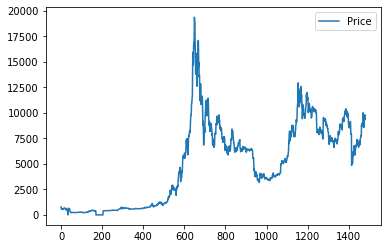

              Price
count   1482.000000
mean    4986.772789
std     4024.305471
min        0.000000
25%      657.155000
50%     5179.650000
75%     8151.250000
max    19356.900000


In [195]:
BTCplot = pd.DataFrame(btc)
BTCplot.plot()
plt.show()
print(BTCplot.describe())

In [196]:
size = int(len(btc) * 0.6)
train, test = btc[0:size], btc[size:len(btc)]
size_test = int(len(test) * 0.5)
test, val = test[0:size_test], test[size_test:]

mse_models = []


max_p = 5
max_d = 1
max_q = 5

grid = np.array([(p,d,q) for p in range(max_p+1) for d in range(max_d+1) for q in range(max_q+1)])

risultati = []

for i in tqdm.tqdm(range(1,len(grid))): # for each configuration pdq
    p = grid[i,0]
    d = grid[i,1]
    q = grid[i,2]
    predictions_one_model = []
    mse = []
    mse.append((p,d,q))
    history = [x for x in train]
    try:
        for t in range(len(test)): # fit one model for each forecast
            Arima = ARIMA(history, order=(p,d,q))
            Arima_fit = Arima.fit(disp=0)
            output = Arima_fit.forecast()
            yhat = output[0]
            predictions_one_model.append(yhat)
            obs = test.iloc[t]
            history.append(obs)
        mse.append(mean_squared_error(test, predictions_one_model))
    except Exception:
        mse.append(float("inf")) # if there were problems with invertibility, ... estimate
    mse_models.append(mse)


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [3:27:26<00:00, 175.31s/it]


In [197]:
mse_models

[[(0, 0, 1), 3016830.2259360747],
 [(0, 0, 2), inf],
 [(0, 0, 3), inf],
 [(0, 0, 4), inf],
 [(0, 0, 5), inf],
 [(0, 1, 0), 92382.33037676223],
 [(0, 1, 1), 94436.14270989235],
 [(0, 1, 2), 94862.08380428112],
 [(0, 1, 3), 95571.53939729012],
 [(0, 1, 4), 96185.85788603817],
 [(0, 1, 5), 95253.47847727028],
 [(1, 0, 0), 92597.76549370792],
 [(1, 0, 1), 94735.24512173249],
 [(1, 0, 2), 95170.8115902334],
 [(1, 0, 3), 95853.75476358019],
 [(1, 0, 4), 96451.6566842678],
 [(1, 0, 5), 95508.30332061613],
 [(1, 1, 0), 94504.45299670394],
 [(1, 1, 1), 95281.55091558905],
 [(1, 1, 2), inf],
 [(1, 1, 3), inf],
 [(1, 1, 4), inf],
 [(1, 1, 5), inf],
 [(2, 0, 0), 94761.64766142752],
 [(2, 0, 1), 95514.3409406315],
 [(2, 0, 2), inf],
 [(2, 0, 3), inf],
 [(2, 0, 4), inf],
 [(2, 0, 5), inf],
 [(2, 1, 0), 94859.69123928207],
 [(2, 1, 1), 95125.61473095695],
 [(2, 1, 2), 98198.78192339097],
 [(2, 1, 3), inf],
 [(2, 1, 4), inf],
 [(2, 1, 5), inf],
 [(3, 0, 0), 95138.15209948122],
 [(3, 0, 1), 95437.23843

In [198]:
best_order = mse_models[np.argmin([err for order,err in mse_models])][0]
best_order

(0, 1, 0)

In [199]:
predictions_val = []
history = [x for x in btc[0:size+size_train]]
for t in range(len(val)):#adatto un modello per ogni previsione
            Arima = ARIMA(history, order=best_order)
            Arima_fit = Arima.fit(disp=0)
            output = Arima_fit.forecast()
            yhat = output[0]
            predictions_val.append(yhat)
            obs = val.iloc[t]
            history.append(obs)

### Accuracy based on upside/downside forecast

In [200]:
counter_ok = 0
start = len(train)+len(test)
for i in range(len(val)):
    if(btc[start+i]>btc[start+i-1]):
        rialzo = 1
    else:
        rialzo = 0
    if(predictions_val[i]>btc[start+i-1]):
        pred = 1
    else:
        pred = 0
    if(pred == rialzo):
        counter_ok +=1
        
acc = counter_ok/len(val)
acc

0.4983164983164983

## 5. Exploratory analysis<a id=ae> </a>

### Import the libraries

In [5]:
from sklearn.model_selection import train_test_split as tts
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import itertools
import matplotlib.pyplot as plt
from collections import Counter

In [62]:
# with open("train.pickle", "wb") as f:
#     pickle.dump([text, stemmed_text,btc,date], f)

In [6]:
with open("train.pickle", "rb") as f:
    text, stemmed_text,btc,date = pickle.load(f)

### Creation of tags

In [7]:
min_data = datetime.strptime("2014-01-29", "%Y-%m-%d")

In [8]:
prev_val = btc_scraper(min_data + dt.timedelta(-1), min_data).iloc[0, 1]

In [9]:
y = btc.copy()
if y[0] <= prev_val:
    y[0] = 0
else: y[0] = 1
for i in range(1,len(y)):
    if y[i] <= btc[i-1]:
        y[i] = 0
    else: y[i] = 1

### Matrix creation of the stem

In [210]:
def add_spaces(doc): # function to use stemmed_text with CountVectorizer ()
    string = ""
    for word in doc:
        string = string + word + " "
    return string[0:-1]


vec = CountVectorizer()
X = vec.fit_transform(add_spaces(doc) for doc in stemmed_text)
X = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

### Bar charts

In [15]:
token_pos = list(itertools.chain.from_iterable(list(itertools.compress(stemmed_text, y == 1))))
token_neg = list(itertools.chain.from_iterable(list(itertools.compress(stemmed_text, y == 0))))

In [16]:
hashtag_pos = [token for token in token_pos if token.startswith("#")]
hashtag_neg = [token for token in token_neg if token.startswith("#")]

print("hashtag appartenenti a tweet associati ad un andamento positivo di BTC:\n{}".format(hashtag_pos[:10])) # hashtags belonging to tweets associated with a positive trend of BTC

print("\nhashtag appartenenti a tweet associati ad un andamento negativo di BTC:\n{}".format(hashtag_neg[:10])) # hashtags belonging to tweets associated with a negative trend of BTC

hashtag appartenenti a tweet associati ad un andamento positivo di BTC:
['#blockstack', '#homeschool', '#blockstacksummit', '#bitcoin', '#nyc', '#hourofcod', '#productivityp', '#pennyarcad', '#bestschoolday', '#model3']

hashtag appartenenti a tweet associati ad un andamento negativo di BTC:
['#randpaul', '#netneutr', '#rolemodel', '#usvconvers', '#ksff2015pic', '#flight', '#womenintech', '#nyc', '#soundcloud', '#np']


In [17]:
c_token_pos = Counter(token_pos)
c_token_neg = Counter(token_neg)
c_hashtag_pos = Counter(hashtag_pos)
c_hashtag_neg = Counter(hashtag_neg)

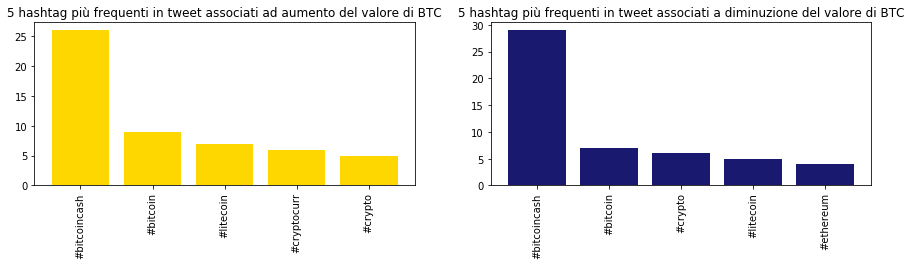

In [18]:
N = 5

plt.figure(figsize=(15, 3))

plt.subplot(121)
plt.title("{} hashtag più frequenti in tweet associati ad aumento del valore di BTC".format(N)) # most frequent hashtags in tweets associated with an increase in the value of BTC
plt.bar(*zip(*c_hashtag_pos.most_common(N)), color="gold")
plt.xticks(rotation="vertical")

plt.subplot(122)
plt.title("{} hashtag più frequenti in tweet associati a diminuzione del valore di BTC".format(N)) # more frequent hashtags in tweets associated with a decrease in the value of BTC
plt.bar(*zip(*c_hashtag_neg.most_common(N)), color="midnightblue")
plt.xticks(rotation="vertical")

plt.show()

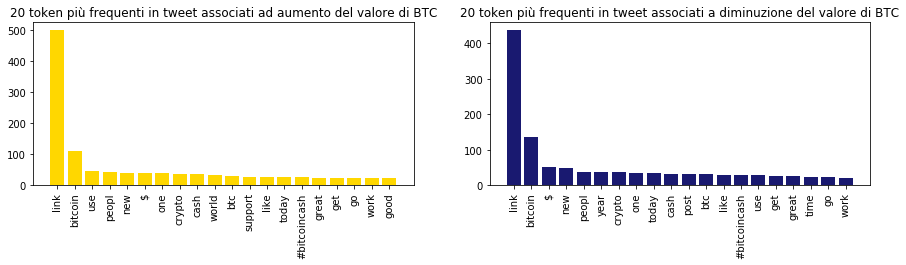

In [19]:
N = 20

plt.figure(figsize=(15, 3))

plt.subplot(121)
plt.title("{} token più frequenti in tweet associati ad aumento del valore di BTC".format(N)) # more frequent tokens in tweets associated with an increase in the value of BTC
plt.bar(*zip(*c_token_pos.most_common(N)), color="gold")
plt.xticks(rotation="vertical")

plt.subplot(122)
plt.title("{} token più frequenti in tweet associati a diminuzione del valore di BTC".format(N)) # more frequent tokens in tweets associated with a decrease in the value of BTC
plt.bar(*zip(*c_token_neg.most_common(N)), color="midnightblue")
plt.xticks(rotation="vertical")

plt.show()

## WordCloud chart

In [30]:
from wordcloud import WordCloud
MASK = plt.imread("figures/btc2.jpg")
MAX_WORDS = 300
MAX_FONT_SIZE = 250
RELATIVE_SCALING = 0


wc_pos = WordCloud(
    mask=MASK,
    max_words=MAX_WORDS, 
    background_color="white",
    max_font_size=MAX_FONT_SIZE,
    relative_scaling=RELATIVE_SCALING,
).generate_from_frequencies(c_token_pos)

wc_neg = WordCloud(
    mask=MASK[:, ::-1, :],
    max_words=MAX_WORDS,
    background_color="black",
    max_font_size=MAX_FONT_SIZE,
    relative_scaling=RELATIVE_SCALING,
    colormap=plt.cm.YlOrRd
).generate_from_frequencies(c_token_neg)


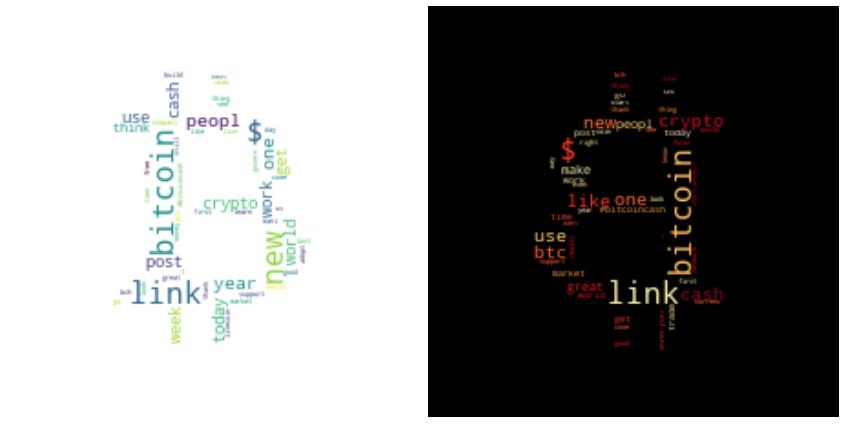

In [31]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")

plt.subplot(122)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## 6. Classification models<a id=mod></a>

### Import the libraries

In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Division in Train, Test and Validation

In [233]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.40)
X_test, X_val, y_test, y_val = tts(X_test, y_test, test_size=0.50)

In [234]:
with open("XY.pickle", "wb") as f:
    pickle.dump([X, X_train, X_test, X_val, y, y_train, y_test, y_val], f)

In [3]:
with open("XY.pickle", "rb") as f:
    X, X_train, X_test, X_val, y, y_train, y_test, y_val = pickle.load(f)

In [236]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1482, 4494)
(889, 4494)
(296, 4494)
(297, 4494)


In [14]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Dummy classifier

In [238]:
dc = DummyClassifier(strategy="most_frequent")

dc.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

y_pred = dc.predict(X_val)

mc = confusion_matrix(y_val, y_pred, labels=[0,1])
print("\nMatrice di confusione dc: \n {}".format(mc)) # Confusion Matrix

dt_cr = classification_report(y_val, y_pred, output_dict=False)
print("\nReport di classificazione dc: \n {}".format(dt_cr)) # Classification report

dc_acc = accuracy_score(y_val, y_pred)
print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc)) # Accuracy 



Matrice di confusione dc: 
 [[  0 138]
 [  0 159]]

Report di classificazione dc: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       138
         1.0       0.54      1.00      0.70       159

    accuracy                           0.54       297
   macro avg       0.27      0.50      0.35       297
weighted avg       0.29      0.54      0.37       297

Accuratezza DummyClassifier("most_frequent"): 53.5%


### Decision Tree Classifier

In [240]:
dtc = DecisionTreeClassifier()
dtc.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))
dtc_y_pred = dtc.predict(X_val)

dt_cr = classification_report(y_val, dtc_y_pred, output_dict=False)
print("Report di classificazione Albero non ottimizzato: \n {}".format(dt_cr)) # Tree (not optimized) classification report

dt_acc = accuracy_score(y_val, dtc_y_pred)

print('Accuratezza Albero non ottimizzato: {:.1f}%'.format(100 * dt_acc)) # Accuracy Tree (not optimized)

mc = confusion_matrix(y_val, dtc_y_pred, labels=[0,1])
print("\nMatrice di confusione Albero non ottimizzato: \n {}".format(mc)) # Confusion Matrix Tree (not optimized)


Report di classificazione Albero non ottimizzato: 
               precision    recall  f1-score   support

         0.0       0.50      0.44      0.47       138
         1.0       0.56      0.62      0.59       159

    accuracy                           0.54       297
   macro avg       0.53      0.53      0.53       297
weighted avg       0.54      0.54      0.54       297

Accuratezza Albero non ottimizzato: 53.9%

Matrice di confusione Albero non ottimizzato: 
 [[61 77]
 [60 99]]


### Choice of optimal hyperparameters

In [241]:
param_grid = ParameterGrid({
    "max_depth": np.arange(1, 30,4),
    "min_samples_leaf": 2 ** np.arange(5),
    "min_impurity_decrease": 10 ** np.arange(-5,-3,0.05)
})

risultati = []

for params in tqdm.tqdm(param_grid):
    dtc.set_params(**params)
    dtc.fit(X_train, y_train)
    dtc_y_pred = dtc.predict(X_test)
    params["accuracy_score"] = accuracy_score(y_test, dtc_y_pred)
    risultati.append(params)
    
risultatiDF = pd.DataFrame(risultati)

100%|██████████████████████████████████████████████████████████████████████████████| 1600/1600 [12:45<00:00,  2.09it/s]


In [242]:
risultatiDF = risultatiDF.sort_values(["accuracy_score","max_depth","min_impurity_decrease","min_samples_leaf"],ascending = [False,True,False,False])
risultatiDF

,max_depth,min_impurity_decrease,min_samples_leaf,accuracy_score
399,5,0.000891,16,0.550676
394,5,0.000794,16,0.550676
389,5,0.000708,16,0.550676
384,5,0.000631,16,0.550676
379,5,0.000562,16,0.550676
...,...,...,...,...
1220,25,0.000016,1,0.486486
1200,25,0.000010,1,0.486486
1375,25,0.000562,1,0.483108
1360,25,0.000398,1,0.483108


col_0  count
Price       
0.0      420
1.0      469


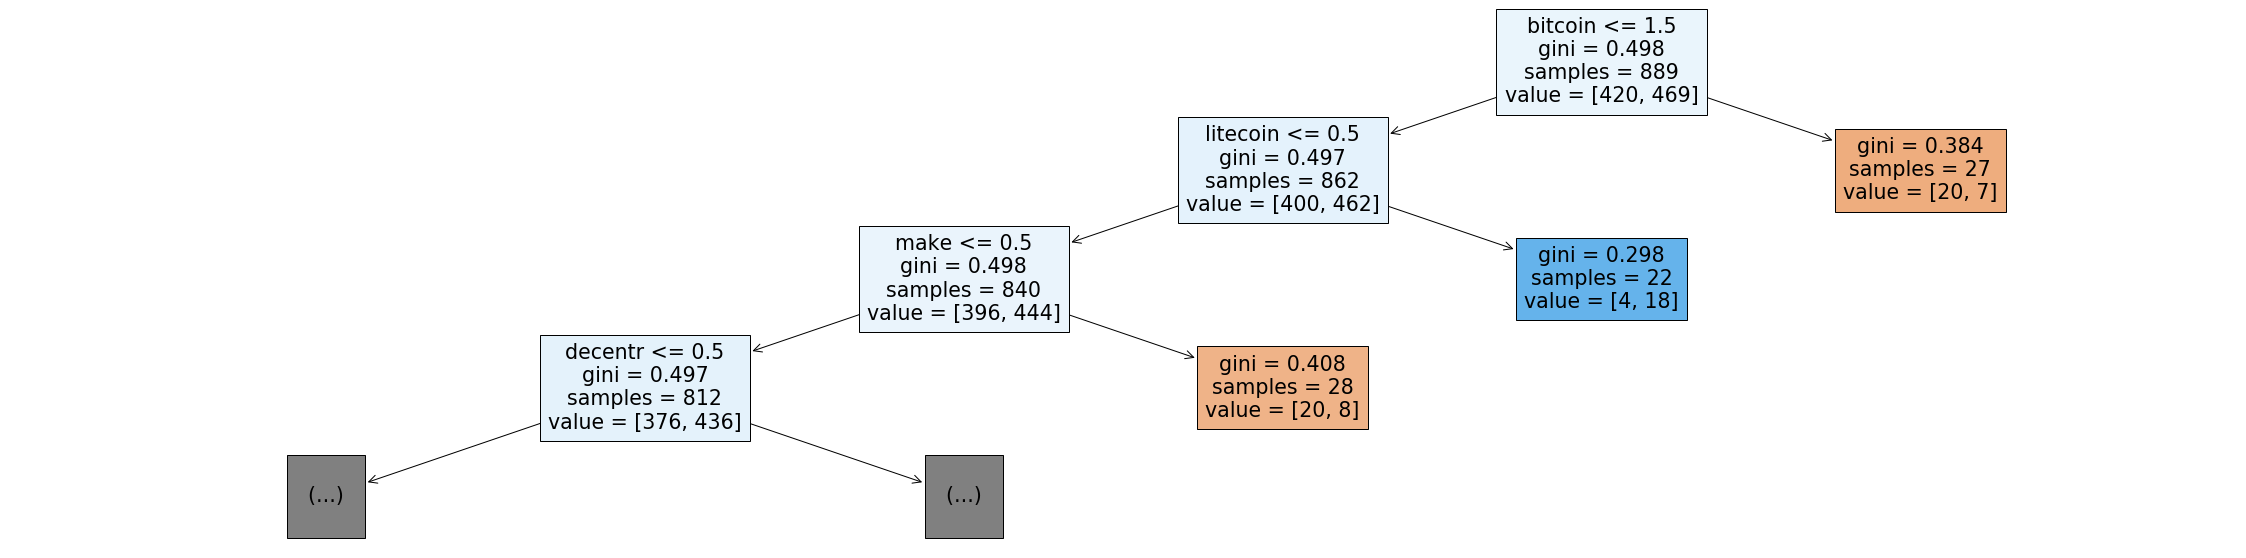

In [243]:
plt.figure(figsize=(40,10))
my_tab = pd.crosstab(index=y_train,columns="count")
print(my_tab)
a = plot_tree(dtc,max_depth = 3,feature_names = X.columns,filled=True)

In [244]:
dtc.set_params(**param_grid[risultatiDF.index[0]])#parametri miglior modello
dtc.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))
dtc_y_pred = dtc.predict(X_val)

dt_cr = classification_report(y_val, dtc_y_pred, output_dict=False)
print("Report di classificazione Albero ottimizzato: \n {}".format(dt_cr)) # Optimized Tree classification report

dt_acc = accuracy_score(y_val, dtc_y_pred)

print('Accuratezza Albero ottimizzato: {:.1f}%'.format(100 * dt_acc)) # Accuracy Optimized Tree

mc = confusion_matrix(y_val, dtc_y_pred, labels=[0,1])
print("\nMatrice di confusione Albero ottimizzato: \n {}".format(mc)) # Matrice di confusione Optimized Tree

Report di classificazione Albero ottimizzato: 
               precision    recall  f1-score   support

         0.0       0.55      0.09      0.15       138
         1.0       0.54      0.94      0.69       159

    accuracy                           0.54       297
   macro avg       0.54      0.51      0.42       297
weighted avg       0.54      0.54      0.44       297

Accuratezza Albero ottimizzato: 54.2%

Matrice di confusione Albero ottimizzato: 
 [[ 12 126]
 [ 10 149]]


### Regularized logistic regression

In [19]:
rl = LogisticRegression(
    penalty="l1",
    solver="saga",
    n_jobs=-1)

In [20]:
param_grid = ParameterGrid({'C': 10**np.arange(-5,0,0.1)})

risultati = []

for params in tqdm.tqdm(param_grid):
    rl.set_params(**params, max_iter = 1000)
    rl.fit(X_train, y_train)
    rl_y_pred = rl.predict(X_test)
    params["accuracy_score"] = accuracy_score(y_test, rl_y_pred)
    risultati.append(params)
    
risultatiDF = pd.DataFrame(risultati)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:34<00:00,  1.89s/it]


In [21]:
risultatiDF = risultatiDF.sort_values(["accuracy_score", "C"],ascending = [False, True])
risultatiDF.head()

,C,accuracy_score
41,0.125893,0.547297
40,0.100000,0.543919
42,0.158489,0.543919
46,0.398107,0.543919
0,0.000010,0.540541


In [22]:
rl.set_params(**param_grid[risultatiDF.index[0]])#parametri miglior modello
rl.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))
rl_y_pred = rl.predict(X_val)

rl_cr = classification_report(y_val, rl_y_pred, output_dict=False)
print("Report di classificazione Regressione Logistica Regolarizzata via Verosimiglianza Penalizzata: \n {}".format(rl_cr)) # Regression Logistic Regression Regression Report via Penalized Likelihood

rl_acc = accuracy_score(y_val, rl_y_pred)

print("Accuratezza Regressione Logistica Regolarizzata via Verosimiglianza Penalizzata: \n {:.1f}%".format(100 * rl_acc)) # Accuracy Regression of Regulated Logistics via Penalized Likelihood

mc = confusion_matrix(y_val, rl_y_pred, labels=[0,1])
print("\nMatrice di confusione Regressione Logistica Regolarizzata via Verosimiglianza Penalizzata: \n {}".format(mc)) # Confusion Matrix Regression Logistic Regression via Penalized Likelihood

Report di classificazione Regressione Logistica Regolarizzata via Verosimiglianza Penalizzata: 
               precision    recall  f1-score   support

         0.0       0.53      0.07      0.13       138
         1.0       0.54      0.94      0.69       159

    accuracy                           0.54       297
   macro avg       0.53      0.51      0.41       297
weighted avg       0.53      0.54      0.43       297

Accuratezza Regressione Logistica Regolarizzata via Verosimiglianza Penalizzata: 
 53.9%

Matrice di confusione Regressione Logistica Regolarizzata via Verosimiglianza Penalizzata: 
 [[ 10 128]
 [  9 150]]


### Logistic regression on principal components

In [12]:
# standardization before PCA
Sc = StandardScaler()
Sc.fit(pd.concat([X_train, X_test]))
X_trainST = pd.DataFrame(Sc.transform(X_train)) 
X_testST = pd.DataFrame(Sc.transform(X_test))
X_valST = pd.DataFrame(Sc.transform(X_val))

In [15]:
param_grid = ParameterGrid({'n_components': np.arange(2,30,1)})
Pca = PCA()
Lr = LogisticRegression()

risultati = []

for params in tqdm.tqdm(param_grid):
    Pca.set_params(**params)
    Pca.fit(pd.concat([X_trainST,X_testST]))
    X_trainPC = Pca.transform(X_trainST)#principal components
    X_testPC = Pca.transform(X_testST)
    Lr.fit(X_trainPC, y_train)
    Lr_y_pred = Lr.predict(X_testPC)
    params["accuracy_score"] = accuracy_score(y_test, Lr_y_pred)
    risultati.append(params)
    
risultatiDF = pd.DataFrame(risultati)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:10<00:00,  2.74it/s]


In [16]:
risultatiDF = risultatiDF.sort_values(["accuracy_score", "n_components"],ascending = [False, True])
risultatiDF.head()

,n_components,accuracy_score
19,21,0.567568
12,14,0.564189
14,16,0.564189
25,27,0.564189
8,10,0.560811


In [18]:
Pca.set_params(**param_grid[risultatiDF.index[0]])#parametri miglior modello
Pca.fit(pd.concat([X_trainST,X_testST,X_valST]))
X_ttPC = Pca.transform(pd.concat([X_trainST, X_testST]))
X_valPC = Pca.transform(X_valST)
    
Lr.fit(X_ttPC, pd.concat([y_train, y_test]))
Lr_y_pred = Lr.predict(X_valPC)

Lr_cr = classification_report(y_val, Lr_y_pred, output_dict=False)
print("Report di classificazione Regressione Logistica Regolarizzata con Componenti principali: \n {}".format(Lr_cr)) # Regularized Logistic Regression Classification Report with Principal Components

Lr_acc = accuracy_score(y_val, Lr_y_pred)

print("Accuratezza Regressione Logistica Regolarizzata con Componenti principali: \n {:.1f}%".format(100 * Lr_acc)) # Accuracy Regression Regularized Logistics with Principal Components

mc = confusion_matrix(y_val, Lr_y_pred, labels=[0,1])
print("\nMatrice di confusione Regressione Logistica Regolarizzata con Componenti principali: \n {}".format(mc)) # Confusion Matrix Regularized Logistic Regression with Principal Components

Report di classificazione Regressione Logistica Regolarizzata con Componenti principali: 
               precision    recall  f1-score   support

         0.0       0.39      0.10      0.16       138
         1.0       0.52      0.86      0.65       159

    accuracy                           0.51       297
   macro avg       0.46      0.48      0.41       297
weighted avg       0.46      0.51      0.42       297

Accuratezza Regressione Logistica Regolarizzata con Componenti principali: 
 50.8%

Matrice di confusione Regressione Logistica Regolarizzata con Componenti principali: 
 [[ 14 124]
 [ 22 137]]


### Best model
Basandosi sulla accuracy ottenuta nel validation set, il miglior modello ottenuto è l'albero con iperparametri:
* Profondità massima: 5
* Decremento minimo di impurità: 0.000891
* Numero minimo di elementi nelle foglie: 16


## 7. Pipeline<a id=pip> </a>

### The stages of the pipelines are:
* Data update with writing to file
* Tokenization
* Stop words and Stemming removal
* Matrix creation of styles and Tagging
* Adaptation of the best model

The pipeline will return the forecast of the next btc value

In [33]:
with open("train.pickle", "rb") as f:
    text, stemmed_text,btc,date = pickle.load(f)    

In [34]:
with open("DatiAggiornati.pickle", "wb") as f:
    pickle.dump([text, stemmed_text,btc,date], f)

In [35]:
from sklearn.base import  TransformerMixin, BaseEstimator

class UpdateData(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def user_scraper2(self, user, fr, to, coda=None):
        tweets = query_tweets(query = user,begindate = fr,enddate = to)
        df = pd.DataFrame(t.__dict__ for t in tweets if t.__dict__["screen_name"] == user)
        if coda is None:
            return df
        else:
            coda.put(df)

    def users_scraper2(self, users, fr, to):
        coda = mp.Queue()
        threads = [th.Thread(target=self.user_scraper2, args=(user,fr,to), kwargs={"coda": coda}) for user in users]
        for t in threads:
            t.start()
        dfs = [coda.get() for t in threads]
        for t in threads:
            t.join()
        dfs = [df for df in dfs if not df.dropna().empty]
        df = pd.concat([df for df in dfs], join="inner").reset_index()
        df = df[["timestamp","text"]]
        date = [str(d)[0:10] for d in df.timestamp]
        df.timestamp = date
        df.columns = ["Date","Text"]
        df = df.sort_values(by=["Date"])
        df = df.reset_index(drop=True)
        return df    
    
    def merge_tweets2(self, df):
        n = len(df)
        df1 = pd.DataFrame({"Date":[""]*n,"Text":[""]*n})
        j = 1
        for i in range(1,n):
            if df.iloc[i-1,0] == df.iloc[i,0]:
                df1.iloc[j-1,1] = str(df1.iloc[j-1,1])+" "+str(df.iloc[i,1])
                df1.iloc[j-1,0] = df.iloc[i,0]
                df1 = df1[:-1]
                j -= 1
            else:
                df1.iloc[j-1,:] = df.iloc[i-1,:]
            j += 1
        return df1

    def btc_scraper2(self, startdate, enddate=dt.date.today()):
        q.ApiConfig.api_key = "Vyszw1XDzRfvess2NU9t"
        btc = q.get("BCHARTS/KRAKENUSD", start_date=startdate, end_date=enddate, paginate=True) # Kraken exchange
        btc.to_csv("btc.csv")
        df = pd.read_csv("btc.csv", usecols=["Date","Close"])
        df = pd.DataFrame(df)
        df.columns = ["Date","Price"]
        return df
    
    def del_tweets2(self, tweets,btc):
        idx = []
        m = min(len(tweets),len(btc))
        for i in range(0,m):
            if btc.iloc[0,0] > tweets.iloc[i,0]:
                idx.append(i)
            else:
                break
        tweets = tweets.drop(tweets.index[idx])
        tweets = tweets.reset_index(drop=True)
        return tweets
    
    def del_btc2(self, tweets,btc):
        n = len(btc)
        idx = []
        lis = [d for d in tweets.Date]
        for i in range(0,n):
            if str(btc.iloc[i,0]) not in lis:
                idx.append(i)
        btc = btc.drop(btc.index[idx])
        btc = btc.reset_index(drop=True)
        return btc
    
    def fit(self,X, y=None, **kwargs):
        with open(X, 'rb') as f:
            text, stemmed_text,btc,date = pickle.load(f)    
        with open('DatiAggiornati.pickle', 'wb') as f:
            pickle.dump([text, stemmed_text,btc,date], f)
        profiles = ["BTCTN","Bitcoin","BTCNews247","justinsuntron","officialmcafee","VitalikButerin","SatoshiLite","APompliano",
           "naval","pmarca","fredwilson","rogerkver","cdixon","aantonop","cz_binance","ErikVoorhees","PeterLBrandt",
           "brian_armstrong"]
        today = dt.date.today()
        last_scraped = dt.datetime.strptime((date[len(date)-1]), '%Y-%m-%d').date()
        df = self.users_scraper2(users = profiles, fr = last_scraped, to = today)
        text = self.merge_tweets2(df)
        btc = self.btc_scraper2(last_scraped,today)
        text = self.del_tweets2(text,btc)
        btc = self.del_btc2(text,btc)
        date = btc.Date
        btc = btc.Price
        with open(X, 'rb') as f:
            text_vecchio, stemmed_text,btc_vecchio,date_vecchio = pickle.load(f)
        self.text = pd.concat([text_vecchio,text]).reset_index(drop=True)
        self.date = pd.concat([date_vecchio,date]).reset_index(drop=True)
        self.btc  = pd.concat([btc_vecchio,btc]).reset_index(drop=True)
        
    def transform(self,X, y=None, **kwargs):        
        with open("DatiAggiornati_NoStem.pickle", "wb") as f:
            pickle.dump([self.text, self.btc, self.date], f)
    
    def fit_transform(self,X, y=None, **kwargs): 
        self.fit(X)
        self.transform(X)
        return (self.text)

In [36]:
class My_tokenizer():
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None, **kwargs):
        self.tokenizer = tt(preserve_case=False, reduce_len=True, strip_handles=True)
    
    def transform(self,X, y=None, **kwargs):  
        text = X.Text
        text = [bs(t, "lxml").get_text() for t in text]
        text = [re.sub("http\S+", " link ", t) for t in text]
        self.text = [self.tokenizer.tokenize(t) for t in text]
        
    def fit_transform(self,X, y=None, **kwargs): 
        self.fit(X)
        self.transform(X)
        return (self.text)

In [37]:
class My_stemmer():
    
    def __init__(self):
        pass
    
    def pulisci_parola(self,s):
        return "".join(re.findall("[a-zA-Z0-9$#]+", s))
    
    def fit(self, X, y=None, **kwargs):
        self.stop_words = sw.words("english")+list(pun.replace("$",""))
        self.stemmer = ss("english")

    def transform(self,X, y=None, **kwargs): 
        stemmed_text = []
        text = X

        for i in range(len(text)):
            stemmed_text.append([])
            for j in range(len(text[i])):
                s = self.pulisci_parola(text[i][j])
                if s not in self.stop_words and s !="":
                    stemmed_text[i].append(self.stemmer.stem(s))

        self.stemmed_text = stemmed_text
        with open("DatiAggiornati_NoStem.pickle", "rb") as f:
            text, btc, date = pickle.load(f)  
        with open("DatiAggiornati.pickle", "wb") as f:
            pickle.dump([text, self.stemmed_text,btc,date], f)
    
    def fit_transform(self,X, y=None, **kwargs): 
        self.fit(X)
        self.transform(X)
        return (self.stemmed_text)   

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

class To_XY():
    
    def __init__(self):
        pass
    
    def btc_scraper(self, startdate, enddate=dt.date.today()):
        q.ApiConfig.api_key = "Vyszw1XDzRfvess2NU9t"
        btc = q.get("BCHARTS/KRAKENUSD", start_date=startdate, end_date=enddate, paginate=True) #Kraken exchange
        btc.to_csv("btc.csv")
        df = pd.read_csv("btc.csv", usecols=["Date","Close"])
        df = pd.DataFrame(df)
        df.columns = ["Date","Price"]
        return df
    
    def add_spaces(self, doc):
        string = ""
        for word in doc:
            string = string + word + " "
        return string[0:-1]
    
    def fit(self, X, y=None, **kwargs):
        min_data = datetime.strptime("2014-01-29", "%Y-%m-%d")
        self.prev_val = self.btc_scraper(min_data + dt.timedelta(-1), min_data).iloc[0, 1]
        with open("DatiAggiornati.pickle", "rb") as f:
            text, st, btc, date = pickle.load(f)
        
        self.vec = CountVectorizer()
        self.btc = btc
    
    def transform(self,X, y=None, **kwargs):
        stemmed_text = X
        stems_matrix = self.vec.fit_transform(self.add_spaces(doc) for doc in stemmed_text)
        self.stems_matrix = pd.DataFrame(stems_matrix.toarray(), columns=self.vec.get_feature_names())
        y = self.btc.copy()
        if y[0] <= self.prev_val:
            y[0] = 0
        else: y[0] = 1
        for i in range(1,len(y)):
            if y[i] <= self.btc[i-1]:
                y[i] = 0
            else: y[i] = 1
        if(len(y) == self.stems_matrix.shape[0]):
            y = y[:-1] #rimuovo il valore se non è di chiusura
        self.y = y    
        
    def fit_transform(self,X, y=None, **kwargs): 
        self.fit(X)
        self.transform(X)
        return self.stems_matrix,self.y

In [39]:
class Make_prediction():
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None, **kwargs):
        y = X[1]
        self.newday = X[0].tail(1)
        X = X[0].iloc[:-1]
        self.dtc = DecisionTreeClassifier()
        self.dtc.fit(X,y)
    
    def transform(self,X, y=None, **kwargs):
        self.predict = self.dtc.predict(self.newday)
    
    def fit_transform(self,X, y=None, **kwargs): 
        self.fit(X)
        self.transform(X)
        return self.predict 

In [40]:
pipl = Pipeline(steps = [("Aggiornamento_dati", UpdateData()),
                         ("Tokenizzatore", My_tokenizer()),
                         ("Stemmer-Rimozione_StopWords", My_stemmer()),
                         ("Creazione_Matrice_Stilemi-Tagging", To_XY()),
                         ("Adattamento_Albero-Previsione", Make_prediction())
                        ])

predict = pipl.fit_transform("DatiAggiornati.pickle")

INFO: queries: ['BTCNews247 since:2020-05-24 until:2020-05-25', 'BTCNews247 since:2020-05-25 until:2020-05-26', 'BTCNews247 since:2020-05-26 until:2020-05-27']
INFO: queries: ['VitalikButerin since:2020-05-24 until:2020-05-25', 'VitalikButerin since:2020-05-25 until:2020-05-26', 'VitalikButerin since:2020-05-26 until:2020-05-27']
INFO: queries: ['Bitcoin since:2020-05-24 until:2020-05-25', 'Bitcoin since:2020-05-25 until:2020-05-26', 'Bitcoin since:2020-05-26 until:2020-05-27']
INFO: queries: ['BTCTN since:2020-05-24 until:2020-05-25', 'BTCTN since:2020-05-25 until:2020-05-26', 'BTCTN since:2020-05-26 until:2020-05-27']
INFO: queries: ['officialmcafee since:2020-05-24 until:2020-05-25', 'officialmcafee since:2020-05-25 until:2020-05-26', 'officialmcafee since:2020-05-26 until:2020-05-27']
INFO: queries: ['justinsuntron since:2020-05-24 until:2020-05-25', 'justinsuntron since:2020-05-25 until:2020-05-26', 'justinsuntron since:2020-05-26 until:2020-05-27']
INFO: queries: ['SatoshiLite si

In [41]:
if(predict == 0): print("Il prossimo valore in chiusura di BTC è previsto in ribasso") # The next BTC closing value is expected to fall
else: print("Il prossimo valore in chiusura di BTC è previsto in rialzo") # The next closing value of BTC is expected to rise

Il prossimo valore in chisura di BTC è previsto in rialzo


### Verify data update

In [48]:
with open("DatiAggiornati.pickle", "rb") as f:
    text, stemmed_text,btc,date = pickle.load(f)  
date.tail(10)

1324    2020-05-18
1325    2020-05-19
1326    2020-05-20
1327    2020-05-21
1328    2020-05-22
1329    2020-05-23
1330    2020-05-24
1331    2020-05-24
1332    2020-05-25
1333    2020-05-26
Name: Date, dtype: object